In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import idct, dct
import sys

***Problem 1 : JPEG implementation***

In [2]:
def dct2(block):
  N = 8
  F = np.zeros((N, N))
  for u in range(N):
    for v in range(N):
      sum_val = 0
      for x in range(N):
        for y in range(N):
          sum_val += block[x, y] * np.cos((2 * x + 1) * u * np.pi / (16 * N)) * np.cos((2 * y + 1) * v * np.pi / (16 * N))
      F[u, v] = 1 / (4 * N) * sum_val
  return F
def perform_dct_on_patches(image):
  image_height, image_width = image.shape
  dct_coefficients = []
  for y in range(0, image_height, 8):
    for x in range(0, image_width, 8):
      # Extract 8x8 patch
      patch = image[y:y+8, x:x+8]
      # Apply 2D DCT
      dct_coeff = dct(dct(patch, axis=0, norm='ortho'), axis=1, norm='ortho')
      dct_coefficients.append(dct_coeff)
  return dct_coefficients

In [3]:
Q = np.array([  [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56], 
                [14, 17, 22, 29, 51, 87, 80, 62], 
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99] ], dtype=float)
image = np.array(Image.open("cameraman.tif").convert('L'), dtype = float)
print(image.shape)
dct_transformed = perform_dct_on_patches(image)
dct_transformed2 = np.array(dct_transformed)
print(dct_transformed2.shape)
y = np.floor(dct_transformed2 / Q + 0.5)
print(y.shape)

(256, 256)
(1024, 8, 8)
(1024, 8, 8)


In [4]:
dct_image = np.zeros(image.shape, dtype = float)
for i in range(32):
    for j in range(32):
        dct_image[i*8 : (i+1)*8, j*8 : (j + 1)*8] = y[i *32 + j]

In [5]:
def getBin(x):
    no_of_bits = int(np.ceil(np.log2(np.abs(x)+1)))
    val = []
    for _ in range(no_of_bits):
        val.append("1")
    val.append("0")

    if(x < 0):
        x = x + np.power(2, no_of_bits) - 1
    x = bin(x)[2 : ]
    zeros = ""
    for _ in range(no_of_bits - len(x)):
        zeros += "0"
    val += zeros + x
    return "".join(val)


In [6]:
y_flat = y.flatten()
bitstream = ""
for elem in y_flat:
    bitstream += getBin(int(elem))

In [7]:
print(len(bitstream) / (1024 * 8), "kibi Bytes after JPEG")
print((sys.getsizeof(255.) * image.size) / 1024.0, "kibi Bytes of original image")

20.0325927734375 kibi Bytes after JPEG
1536.0 kibi Bytes of original image


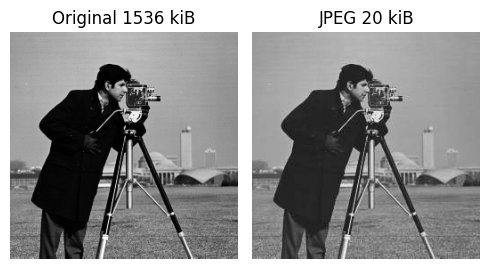

MSE =  44.54563508062465


In [8]:
x_cap = y * Q
# print(x_cap.shape)
reconstructed = []
for x in x_cap:
    reconstructed.append(idct(idct(x, axis=0, norm='ortho'), axis=1, norm='ortho'))
reconstructed = np.array(reconstructed)
reconstructed_image = np.zeros(image.shape)
for i in range(32):
    for j in range(32):
        reconstructed_image[i*8 : (i+1)*8, j*8 : (j + 1)*8] = reconstructed[i *32 + j]
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
axes[0].set_title(f"Original {int((sys.getsizeof(255.) * image.size) / 1024.0)} kiB")
axes[1].set_title(f"JPEG {int(len(bitstream) / (1024. * 8.))} kiB")

axes[0].imshow(image, cmap='gray')
axes[1].imshow(reconstructed_image, cmap='gray')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

mse = np.sum(np.square(image - reconstructed_image)) / image.size
print("MSE = ", mse)

In [16]:
def mse(image1, image2):
   
    err = np.sum((np.array(image1, dtype="float") - np.array(image2, dtype="float")) ** 2)
    err /= float(image1.size[0] * image1.size[1])
    return err

In [17]:
def compress_image_default(input_path, output_path, quality):
   
    Image.open(input_path).save(output_path, format="JPEG", quality=quality)

In [18]:
def compress_image_default(input_path, output_path, quality):
   
    Image.open(input_path).save(output_path, format="JPEG", quality=quality)

In [19]:
def get_image_size(file_path):
   
    import os
    return os.path.getsize(file_path)

In [20]:
input_image_path = "cameraman.tif"
 
 
desired_mse = 44.54563508062465
 
 
mse_tolerance = 0.3
 
 
output_path = "compressed_image.jpg"
 
 
final_quality = None
compressed_file_size = None
 
 
for current_quality in range(1, 101):
 
    compress_image_default(input_image_path, output_path, current_quality)
   
 
    original_image = Image.open(input_image_path)
    compressed_image = Image.open(output_path)
   
 
    current_mse = mse(original_image, compressed_image)
   
 
    if abs(current_mse - desired_mse) <= mse_tolerance:
        print(current_mse)
        final_quality = current_quality
        compressed_file_size = get_image_size(output_path)/1024
        break
 
 
print(f"Final Quality: {final_quality}")
print(f"Compressed Image Size: {compressed_file_size} Kilo bytes")
 

44.25398254394531
Final Quality: 49
Compressed Image Size: 6.9560546875 Kilo bytes


***Problem 2 : Comparison of perceptual quality measures***

In [15]:
def PSNR(img1, img2):
    if(img1.shape != img2.shape):
        return -1
    mse = np.sum(np.square(img1 - img2)) / img1.size
    if(np.max(img1) <= 1.0):
        max_pixel_val = 1.0
    else:
        max_pixel_val = 255.0
    return 10 * np.log10(max_pixel_val / np.sqrt(mse))

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float

def SSIM(img1, img2):
    img_1 = img_as_float(img1)
    img_2 = img_as_float(img2)

    return ssim(img_1, img_2, full=True)